In [1]:
from pyspark.context import SparkContext
from pyspark.sql import functions as F 
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local[*]") \
    .appName("Yellow_Taxi_Trip") \
    .getOrCreate()

In [3]:

path = "2023_Yellow_Taxi_Trip_Data.csv"
df = spark.read.option("header", "true").csv(path)

In [4]:
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- airport_fee: string (nullable = true)



In [5]:
from pyspark.sql.functions import col, sum

# Count null values for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        1309356|            0|   1309356|           1309356|           0|           0|           0|          0|    0|      0|         

In [6]:
# Define a dictionary for filling null values in each column based on assumptions
fill_values = {
    'VendorID': 'unknown',
    'passenger_count': '1',            # assuming 1 passenger if not specified
    'trip_distance': '0.0',            # assuming zero distance if not specified
    'RatecodeID': '1',                 # assuming a default rate code
    'store_and_fwd_flag': 'N',         # assuming 'N' for no store-and-forward
    'PULocationID': '0',
    'DOLocationID': '0',
    'payment_type': 'unknown',
    'fare_amount': '0.0',
    'extra': '0.0',
    'mta_tax': '0.0',
    'tip_amount': '0.0',
    'tolls_amount': '0.0',
    'improvement_surcharge': '0.0',
    'total_amount': '0.0',
    'congestion_surcharge': '0.0',
    'airport_fee': '0.0'
}

# Fill null values
df = df.fillna(fill_values)


In [7]:
from pyspark.sql.types import IntegerType, FloatType, StringType, TimestampType

df = df.withColumn('VendorID', df['VendorID'].cast(IntegerType())) \
       .withColumn('tpep_pickup_datetime', df['tpep_pickup_datetime'].cast(TimestampType())) \
       .withColumn('tpep_dropoff_datetime', df['tpep_dropoff_datetime'].cast(TimestampType())) \
       .withColumn('passenger_count', df['passenger_count'].cast(IntegerType())) \
       .withColumn('trip_distance', df['trip_distance'].cast(FloatType())) \
       .withColumn('RatecodeID', df['RatecodeID'].cast(IntegerType())) \
       .withColumn('PULocationID', df['PULocationID'].cast(IntegerType())) \
       .withColumn('DOLocationID', df['DOLocationID'].cast(IntegerType())) \
       .withColumn('payment_type', df['payment_type'].cast(IntegerType())) \
       .withColumn('fare_amount', df['fare_amount'].cast(FloatType())) \
       .withColumn('extra', df['extra'].cast(FloatType())) \
       .withColumn('mta_tax', df['mta_tax'].cast(FloatType())) \
       .withColumn('tip_amount', df['tip_amount'].cast(FloatType())) \
       .withColumn('tolls_amount', df['tolls_amount'].cast(FloatType())) \
       .withColumn('improvement_surcharge', df['improvement_surcharge'].cast(FloatType())) \
       .withColumn('total_amount', df['total_amount'].cast(FloatType())) \
       .withColumn('congestion_surcharge', df['congestion_surcharge'].cast(FloatType())) \
       .withColumn('airport_fee', df['airport_fee'].cast(FloatType()))


In [8]:
df.createOrReplaceTempView("taxi_data")

In [9]:
# Mean, median, and standard deviation of numerical columns
spark.sql("""
    SELECT 
        AVG(fare_amount) AS avg_fare,
        PERCENTILE(fare_amount, 0.5) AS median_fare,
        STDDEV(fare_amount) AS stddev_fare,
        AVG(trip_distance) AS avg_distance,
        PERCENTILE(trip_distance, 0.5) AS median_distance,
        STDDEV(trip_distance) AS stddev_distance
    FROM taxi_data
""").show()

+------------------+-----------+----------------+-----------------+------------------+------------------+
|          avg_fare|median_fare|     stddev_fare|     avg_distance|   median_distance|   stddev_distance|
+------------------+-----------+----------------+-----------------+------------------+------------------+
|19.522250646691827|       13.5|75.7272886433561|4.088946214785577|1.7899999618530273|241.25089911329852|
+------------------+-----------+----------------+-----------------+------------------+------------------+



In [10]:
# Average fare amount by payment type
spark.sql("""
    SELECT 
        payment_type,
        AVG(fare_amount) AS avg_fare,
        COUNT(*) AS trip_count
    FROM taxi_data
    GROUP BY payment_type
    ORDER BY avg_fare DESC
""").show()


+------------+------------------+----------+
|payment_type|          avg_fare|trip_count|
+------------+------------------+----------+
|           0|22.373174886088183|   1309356|
|           1| 19.81477939058017|  29856932|
|           2|19.388153647845137|   6405059|
|           3|    8.127842588462|    240862|
|           4|1.7246593589624164|    498015|
|           5|               0.0|         2|
+------------+------------------+----------+



In [11]:
spark.sql("""
    SELECT 
        HOUR(tpep_pickup_datetime) AS pickup_hour,
        AVG(fare_amount) AS avg_fare,
        COUNT(*) AS trip_count
    FROM taxi_data
    GROUP BY pickup_hour
    ORDER BY pickup_hour
""").show()


+-----------+------------------+----------+
|pickup_hour|          avg_fare|trip_count|
+-----------+------------------+----------+
|       NULL|19.522250646691827|  38310226|
+-----------+------------------+----------+



In [12]:
spark.sql("""
    SELECT 
        MONTH(tpep_pickup_datetime) AS pickup_month,
        AVG(fare_amount) AS avg_fare,
        COUNT(*) AS trip_count
    FROM taxi_data
    GROUP BY pickup_month
    ORDER BY pickup_month
""").show()


+------------+------------------+----------+
|pickup_month|          avg_fare|trip_count|
+------------+------------------+----------+
|        NULL|19.522250646691827|  38310226|
+------------+------------------+----------+



c:\Users\Keshav Gautam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\Keshav Gautam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
c:\Users\Keshav Gautam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\Keshav Gautam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql

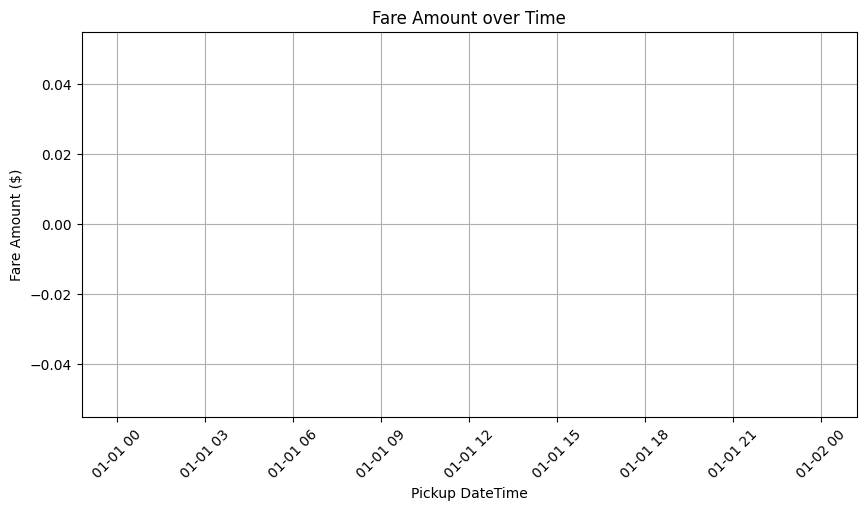

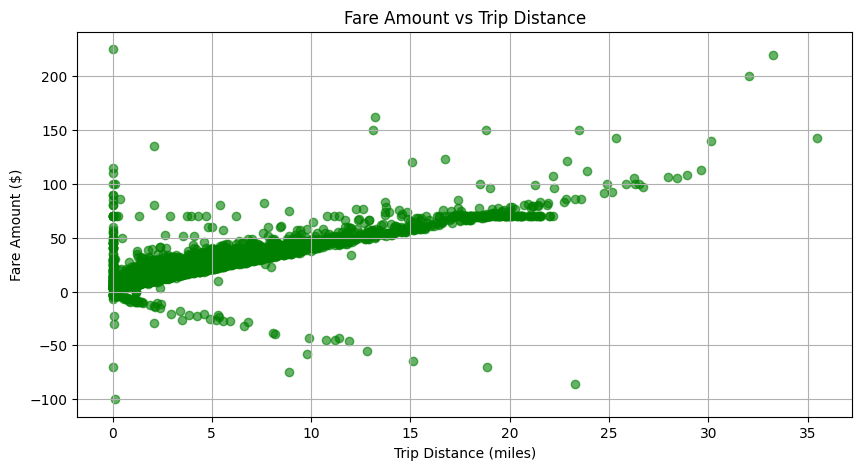

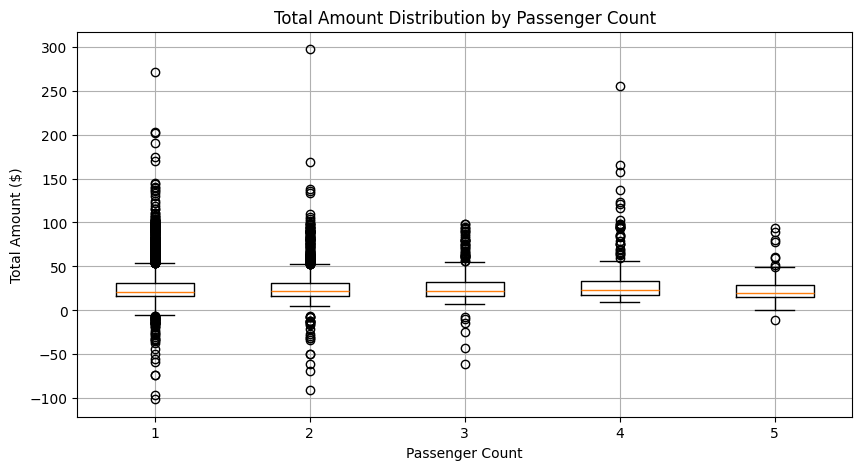

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame
# Limit to 1000 rows, adjust as needed based on memory constraints
pandas_df = df.limit(10000).toPandas()


# Plot 1: Trend of Fare Amount over Time
plt.figure(figsize=(10, 5))
plt.plot(pandas_df['tpep_pickup_datetime'], pandas_df['fare_amount'], marker='o', linestyle='-', color='blue')
plt.title("Fare Amount over Time")
plt.xlabel("Pickup DateTime")
plt.ylabel("Fare Amount ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 2: Relationship between Trip Distance and Fare Amount
plt.figure(figsize=(10, 5))
plt.scatter(pandas_df['trip_distance'], pandas_df['fare_amount'], color='green', alpha=0.6)
plt.title("Fare Amount vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.grid(True)
plt.show()

# Plot 3: Total Amount Distribution by Passenger Count
plt.figure(figsize=(10, 5))
plt.boxplot([pandas_df[pandas_df['passenger_count'] == i]['total_amount'] for i in range(1, 6)], labels=range(1, 6))
plt.title("Total Amount Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Total Amount ($)")
plt.grid(True)
plt.show()


In [14]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- airport_fee: float (nullable = true)



In [15]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2|                NULL|                 NULL|              1|         0.97|         1|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [16]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|            38310226|             38310226|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [17]:
# Drop rows where 'tpep_pickup_datetime' or 'tpep_dropoff_datetime' is null
df = df.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')


In [36]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|                   0|          0|
+--------+---------------+-------------+----------+------------------+------------+-----

In [18]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- airport_fee: float (nullable = true)



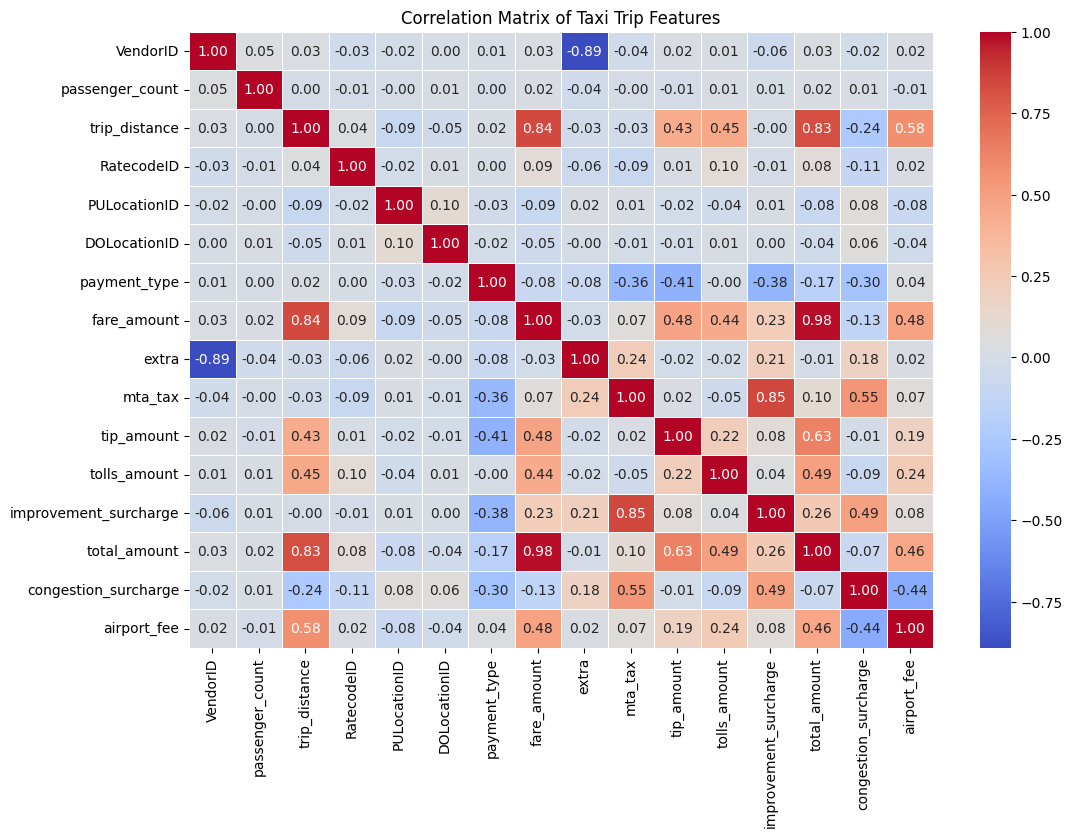

In [19]:
# Drop the 'store_and_fwd_flag' column before converting to Pandas
df_numeric = df.drop('store_and_fwd_flag')
pandas_df = df_numeric.limit(10000).toPandas()

# Calculate the correlation matrix
correlation_matrix = pandas_df.corr()

# Plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Taxi Trip Features")
plt.show()

In [20]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [21]:
from pyspark.ml.feature import VectorAssembler

# Define feature columns
feature_cols = ['trip_distance', 'passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID', 
                'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
                'congestion_surcharge', 'airport_fee']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [22]:
from pyspark.ml.regression import LinearRegression

# Define the model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount")

In [23]:
from pyspark.ml import Pipeline

# Define the pipeline
pipeline = Pipeline(stages=[assembler, lr])

In [24]:
# Fit the pipeline on the training data
model = pipeline.fit(train_data)

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 86.55616114036957
